## Instalaciones

In [1]:
# %pip install -U email-validator
# %pip install gradio
# %pip install pypdf

# Embeddings con OpenAI
Embeddings es un proceso mediante el cual se utiliza alguna tecnica/algoritmo que sea capaz de convertir palabras o texto a vectores de N dimensiones. Estos vectores contienen cierto nivel de información semantica sobre el texto o palabra. Por ejemplo, palabras que son muy similares van a tener valores cercanos en sus representaciones en vectores.

Hay varios modelos que son capaces de hacer un embedding de nuestro texto, en este cuaderno estaremos utilizando el embedding de OpenAI, el cual tiene la capacidad de posicionas muy bien palabras o textos segun su semantica. Este es el mismo embedding que utiliza GPT3. En este cuaderno estarás haciendo embedding de un texto para despues poder buscar cosas dentro de este texto por medio de preguntas en lenguaje natural.

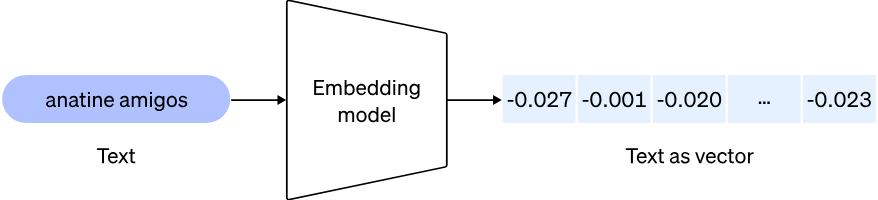

In [2]:
# Importamos todas las dependencias requerida
import gradio as gr
import openai
import pandas as pd
import config
import os
from openai.embeddings_utils import get_embedding
from openai.embeddings_utils import cosine_similarity
from langchain.llms import LlamaCpp, OpenAI

C:\Users\Marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Definimos la API Key para vincular el cuaderno con nuestra cuenta de OpenAI
openai.api_key = os.environ['OPENAI_API_KEY'] = config.OPENAI_API_KEY

# Que es y cómo usar embeddings
Al hacer embedding de un dato, lo estamos convirtiendo a un vector numérico, datos similares estarán más cercanos entre si cuando semanticamente son similares

In [4]:
# Se puede hacer embeeding de palabras o cadenas de texto
palabras = ["casa", "perro", "gato", "lobo", "leon", "zebra", "tigre"]

In [5]:
diccionario = {}
for i in palabras:
    diccionario[i] = get_embedding(i, engine="text-embedding-3-small")

In [6]:
diccionario.keys()

dict_keys(['casa', 'perro', 'gato', 'lobo', 'leon', 'zebra', 'tigre'])

In [7]:
palabra = "gato"
print("Primeros 10 valores de {}:\n".format(palabra), diccionario[palabra][:10])
print("\n")
print("Número de dimensiones del dato embebido\n", len(diccionario[palabra]))

Primeros 10 valores de gato:
 [-0.0016545362304896116, -0.03518657013773918, -0.01752243936061859, 0.03424196317791939, -0.00730298412963748, -0.0079583041369915, -0.013212674297392368, 0.05662912130355835, -0.024004796519875526, -0.03381688892841339]


Número de dimensiones del dato embebido
 1536


## Comparar dos embeddings
Debido a que los embeddings son una representacion vectorial de los datos en un espacio latente, podemos medir la distancia entre dos vectores y asi obtener que tan similares son. Podemos comparar una palabra nueva o alguna de las que ya fueron embebidas 
OJO: No necesariamente es similitud al objeto. Ej. perro y gato aun siendo "opuestos" semanticamente estan cerca pues tienen una relación.

In [8]:
n_palabra = "gato" # Palabra nueva a comparar
palabra_comparar = "perro" # Palabra del diccionario con la que compararemos la nueva palabra
n_palabra_embed = get_embedding(n_palabra, engine="text-embedding-3-small")
similitud = cosine_similarity(diccionario[palabra_comparar], n_palabra_embed)
print(similitud)

0.5013864430314149


# Sumar embeddings
Como los vectores contienen valores numericos, podemos sumarlos y el resultado será un nuevo vector de un concepto que una los elementos sumados

In [9]:
# Suma dos listas usando pandas
sumados = (pd.DataFrame(diccionario["leon"])) + (pd.DataFrame(diccionario["zebra"]))
len(sumados)

for key, value in diccionario.items():
    print(key, ":", cosine_similarity(diccionario[key], sumados))


casa : [0.28493445]
perro : [0.35181523]
gato : [0.38924041]
lobo : [0.52163221]
leon : [0.78427035]
zebra : [0.78427041]
tigre : [0.44565117]


# Aplicacion de un Chatbot

Usaremos Gradio para hacer una interfaz básica donde podremos hacer preguntas y obtendremos una respuesta. 
Para esto reutilizaremos lo que hemos visto hasta el momento pero usaremos el archivo de **chatbot_qa.csv**

In [10]:
def embed_text(path="texto.csv"):
    conocimiento_df = pd.read_csv(path)
    conocimiento_df['Embedding'] = conocimiento_df['texto'].apply(lambda x: get_embedding(x, engine='text-embedding-3-small'))
    conocimiento_df.to_csv('chatbot_embeddings.csv')
    return conocimiento_df

In [11]:
def buscar(busqueda, datos, n_resultados=1):
    busqueda_embed = get_embedding(busqueda, engine="text-embedding-3-small")
    datos["Similitud"] = datos['Embedding'].apply(lambda x: cosine_similarity(x, busqueda_embed))
    datos = datos.sort_values("Similitud", ascending=False)
    return datos.iloc[:n_resultados][["texto", "Similitud", "Embedding"]]

In [12]:
texto_emb = embed_text("./chatbot_respuestas.csv")

In [13]:
with gr.Blocks() as demo:
    busqueda = gr.Textbox(label="Buscar")
    output = gr.DataFrame(headers=['texto'])
    greet_btn = gr.Button("Preguntar")
    greet_btn.click(fn=buscar, inputs=[busqueda, gr.DataFrame(texto_emb)], outputs=output)

In [14]:
demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


# Procesar datos de un PDF
Haremos ahora un ejemplo donde leemos un PDF para poder hacer preguntas y traer un exctracto del PDF

In [16]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter

loader = PyPDFLoader("./archivo_respuestas.pdf")
pages = loader.load_and_split()

In [17]:
# Un elemento por cada página
pages[0].page_content

'DEPARTAMENTO DE CIENCIAS BÁSICAS E INGENIERÍAS  \nCarrera de robots  \nDescripción del evento:  \nEstamos encantados de invitar a todas las y los ingenieros, entusiastas de la robótica \ny mentes creativas a participar en esta emocionante competición donde la innovación \ny la velocidad se encuentran en el corazón de cada diseño.  \n \nLas bases de este concurs o están diseñadas para fomentar la creatividad, el ingenio \ntécnico y la colaboración en la creación de robots veloces. Aquí, en este emocionante \nterreno de juego tecnológico, cada participante tiene la oportunidad de llevar sus \nhabilidades al límite y demo strar que la combinación perfecta de ciencia y arte puede \ndar vida a máquinas capaces de deslumbrarnos con su velocidad y destreza.  \n \nEste concurso no solo se trata de competir, sino también de aprender y compartir \nconocimientos. A través de estas bases, bu scamos no solo destacar el rendimiento \nde los robots, sino también reconocer la originalidad en el diseñ

In [18]:
# Objeto que va a hacer los cortes en el texto
split = CharacterTextSplitter(chunk_size=200, separator='\n')

In [19]:
textos = split.split_documents(pages)  # Lista de textos

In [20]:
print(textos[0].page_content)

DEPARTAMENTO DE CIENCIAS BÁSICAS E INGENIERÍAS  
Carrera de robots  
Descripción del evento:  
Estamos encantados de invitar a todas las y los ingenieros, entusiastas de la robótica


In [21]:
print(textos[1])

page_content='Descripción del evento:  \nEstamos encantados de invitar a todas las y los ingenieros, entusiastas de la robótica \ny mentes creativas a participar en esta emocionante competición donde la innovación' metadata={'source': './archivo_respuestas.pdf', 'page': 0}


In [22]:
# Extraemos la parte de page_content de cada texto y lo pasamos a un dataframe
textos = [str(i.page_content) for i in textos] #Lista de parrafos
parrafos = pd.DataFrame(textos, columns=["texto"])
print(parrafos)

                                                texto
0   DEPARTAMENTO DE CIENCIAS BÁSICAS E INGENIERÍAS...
1   Descripción del evento:  \nEstamos encantados ...
2   y mentes creativas a participar en esta emocio...
3   y la velocidad se encuentran en el corazón de ...
4   Las bases de este concurs o están diseñadas pa...
..                                                ...
85  ● Como jurado tendremos a la Dra. Jessica Mend...
86  educativo de Ingeniería en Datos e Inteligenci...
87  de código; a la Ing. Rosa  Guadalupe Casas de ...
88  educativo de Ingeniería Industrial  en el apar...
89  Contacto  \nDra. Jessica Carmín Mendiola  \njm...

[90 rows x 1 columns]


In [23]:
parrafos['Embedding'] = parrafos["texto"].apply(lambda x: get_embedding(
    x, engine='text-embedding-3-small'))  # Nueva columna con los embeddings de los parrafos
parrafos.to_csv('archivo_embeddings.csv')

In [24]:
# La misma funcion del chatbot de pregunts y respuestas
def embed_text(path="texto.csv"):
    conocimiento_df = pd.read_csv(path)
    conocimiento_df['Embedding'] = conocimiento_df['texto'].apply(lambda x: get_embedding(x, engine='text-embedding-3-small'))
    conocimiento_df.to_csv('archivos_embeddings.csv')
    return conocimiento_df

def buscar(busqueda, datos, n_resultados=1):
    busqueda_embed = get_embedding(busqueda, engine="text-embedding-3-small")
    datos["Similitud"] = datos['Embedding'].apply(lambda x: cosine_similarity(x, busqueda_embed))
    datos = datos.sort_values("Similitud", ascending=False)
    return datos.iloc[:n_resultados][["texto", "Similitud", "Embedding"]]

texto_emb = parrafos
with gr.Blocks() as demo:
    busqueda = gr.Textbox(label="Buscar")
    output = gr.DataFrame(headers=['texto'])
    greet_btn = gr.Button("Preguntar")
    greet_btn.click(fn=buscar, inputs=[busqueda, gr.DataFrame(texto_emb)], outputs=output)

demo.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
